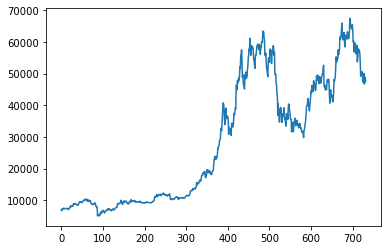

In [1]:
import pandas
import matplotlib.pyplot as plt

dataset = pandas.read_csv('_DATA/crypto/BTC-USD_2019.12.17-2021.12.17.csv', usecols=[1], engine='python')
plt.plot(dataset)
plt.show()

In [2]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

print("Keras ML library imported (with TensorFlow)")

Using TensorFlow backend.


Keras ML library imported (with TensorFlow)


In [3]:
# fix random seed for reproducibility
numpy.random.seed(7)

# load the dataset
dataframe = pandas.read_csv('_DATA/crypto/BTC-USD_2019.12.17-2021.12.17.csv', usecols=[1], engine='python')
dataframe = dataframe.dropna()
dataset = dataframe.values
dataset = dataset.astype('float32')

In [4]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [5]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print("Train data size =", len(train), "Test data size =", len(test))

Train data size = 487 Test data size = 241


In [6]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [7]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# print test arrays X and Y 
#for i in range(len(testX)):
#    print(testX[i], testY[i])

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [8]:
import time

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
print("LSTM network started...")
start_time_ms = time.time() * 1000
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)        # verbose=2
end_time_ms = time.time() * 1000
print("LSTM network finished. Time spent = %.2f seconds" % ((end_time_ms - start_time_ms) / 1000))

LSTM network started...
LSTM network finished. Time spent = 59.57 seconds


In [9]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1090.93 RMSE
Test Score: 2055.60 RMSE


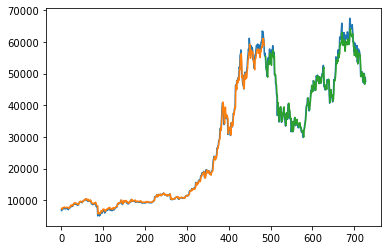

In [10]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [12]:
future = testPredict[(len(testPredict)-2):len(testPredict),:]
#print(type(future))
#print(future.tolist())
future = scaler.transform(future)
#print(future.tolist())                                             # print(len(future)) = 2
forecast_duration = 13;

for i in range(forecast_duration):
    #print("-----------------------------")
    # X = (t)    Y = (t+1)
    futureX = future[(len(future)-2):(len(future)-1),:]            # slice penultimate value
    futureY = [future[len(future)-1,0]]                            # last value as array
    #print('futureX =', futureX.tolist())
    #print('futureY =', futureY)
    futureX = numpy.reshape(futureX, (futureX.shape[0], 1, futureX.shape[1]))
    futurePredict = model.predict(futureX)
    #print('futurePredict =', futurePredict)
    future = numpy.concatenate((future, futurePredict), axis=0)
    #print('Current future =', future.tolist())

future = future[2:,:]
print('Forecast for next', forecast_duration, 'days:', future.tolist())
future = scaler.inverse_transform(future)
print('\nInverse scaled values:', future.tolist())

ERROR! Session/line number was not unique in database. History logging moved to new session 198
Forecast for next 13 days: [[0.6668247580528259], [0.6898772716522217], [0.6668301820755005], [0.6882673501968384], [0.6668351888656616], [0.6867795586585999], [0.6668400168418884], [0.6854032874107361], [0.6668444275856018], [0.6841291189193726], [0.6668485999107361], [0.6829485297203064], [0.6668525338172913]]

Inverse scaled values: [[46710.57421875], [48152.44140625], [46710.91015625], [48051.74609375], [46711.2265625], [47958.6875], [46711.52734375], [47872.60546875], [46711.8046875], [47792.91015625], [46712.0625], [47719.0703125], [46712.30859375]]


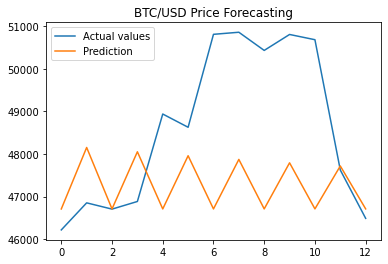

Test Score: 2370.02 RMSE


In [13]:
dataframe_future_real = pandas.read_csv('_DATA/crypto/BTC-USD_2021.12.18-2021.12.30.csv', usecols=[1], engine='python')
dataset_future_real = dataframe_future_real.values
dataset_future_real = dataframe_future_real.astype('float32')

plt.plot(dataset_future_real)
plt.plot(future)
plt.legend(['Actual values', 'Prediction'])
plt.title("BTC/USD Price Forecasting")
plt.show()

futureScore = math.sqrt(mean_squared_error(dataset_future_real, future))
print('Test Score: %.2f RMSE' % (futureScore))